In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/home/lcz/lenlp/text-generation/py_project")

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
from utils.data_loader import load_dataset

In [5]:
train_X, train_Y, test_X = load_dataset()

## 位置编码

In [6]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    
    return pos * angle_rates

In [7]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [10]:
import numpy as np
import tensorflow as tf
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


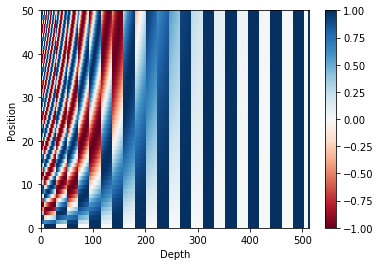

In [12]:
import matplotlib.pyplot as plt

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡

In [60]:
def create_padding_mask(seq):
    pad_index = vocab["<PAD>"]
    seq = tf.cast(tf.math.equal(seq, pad_index), tf.float32)
    
    return seq[:, tf.newaxis, tf.newaxis, :]

In [14]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return mask

## 点积缩放

In [15]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 将 mask 放入到缩放的张量上
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

## 多头注意力

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads 

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [17]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

In [18]:
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)

In [21]:
out.shape

TensorShape([1, 60, 512])

## FFN

In [22]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation="relu"),
        tf.keras.layers.Dense(d_model)
    ])

In [23]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 编码器层

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        # (x-mean) / std,
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [25]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## 解码器层

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        # v, k, q, mask
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [27]:
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [28]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## 编码器

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        
        # 为什么要乘以embedding size的开方？
        # 猜测是因为embedding matrix的初始化方式是xavier init，这种方式的方差是1/embedding size，
        # 因此乘以embedding size的开方使得embedding matrix的方差是1，在这个scale下可能更有利于embedding matrix的收敛。
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [30]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500, maximum_position_encoding=10000)

In [31]:
sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## 解码器

In [32]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # v, k, q
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [33]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer

In [34]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [35]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

In [37]:
from utils.wv_loader import load_vocab

In [38]:
vocab_path = "./../data/vocab.txt"
vocab, reverse_vocab = load_vocab(vocab_path)

In [47]:
vocab["<PAD>"]

32908

In [48]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(vocab)
target_vocab_size = len(vocab)
dropout_rate = 0.1

## 优化器

In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [50]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

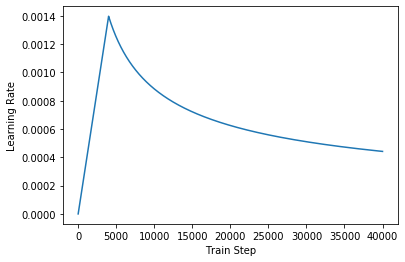

In [51]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [53]:
train_X.shape

(82871, 260)

In [59]:
train_X[0]

array([3.2905e+04, 4.0200e+02, 9.8700e+02, 2.4700e+02, 2.3100e+02,
       4.0200e+02, 4.0000e+00, 1.0000e+01, 9.4000e+01, 4.0000e+00,
       1.0000e+01, 2.4700e+02, 2.3100e+02, 4.0200e+02, 1.0000e+01,
       4.0200e+02, 4.5900e+02, 2.4700e+02, 9.8700e+02, 4.6400e+02,
       1.2100e+02, 1.0000e+00, 5.0000e+00, 1.1000e+01, 5.6400e+02,
       0.0000e+00, 4.8000e+01, 4.5600e+02, 1.6440e+03, 2.0300e+02,
       3.8000e+02, 9.8700e+02, 5.3000e+01, 6.2000e+02, 9.8700e+02,
       2.6695e+04, 4.1400e+02, 3.1700e+02, 2.0700e+02, 1.7000e+01,
       3.2906e+04, 4.7180e+03, 2.3100e+02, 1.0000e+01, 1.1000e+02,
       3.8100e+02, 5.0580e+03, 2.4000e+01, 4.5000e+01, 1.0000e+00,
       7.0000e+01, 3.1700e+02, 2.0080e+03, 3.2907e+04, 3.2908e+04,
       3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e+04,
       3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e+04,
       3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e+04,
       3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e+04, 3.2908e

In [55]:
batch_size = 64
steps_per_epoch = len(train_X) // batch_size
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).shuffle(batch_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [56]:
dataset

<BatchDataset shapes: ((64, 260), (64, 33)), types: (tf.float64, tf.float64)>

In [61]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [62]:
def loss_function(real, pred):
    pad_index = vocab["<PAD>"]
    mask = tf.math.logical_not(tf.math.equal(real, pad_index))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [63]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 训练与检查点

In [64]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [65]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)

    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [66]:
create_masks(np.array([[1,2,3,0,0]]),np.array([[4,5,6,0,0]]))

(<tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[0., 0., 0., 0., 0.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
 array([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[0., 0., 0., 0., 0.]]]], dtype=float32)>)

In [67]:
checkpoint_path = "./data/checkpoints/transformer/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [68]:
EPOCHS = 10

In [69]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [72]:
import time
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[3.2905e+04 5.2000e+02 9.8000e+02 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 [3.2905e+04 4.0200e+02 9.8700e+02 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 [3.2905e+04 9.2500e+02 3.0000e+01 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 ...
 [3.2905e+04 6.5100e+02 6.7080e+03 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 [3.2905e+04 1.4530e+03 8.2000e+01 ... 3.1000e+01 2.0000e+00 3.2907e+04]
 [3.2905e+04 9.5000e+01 3.4980e+03 ... 3.2908e+04 3.2908e+04 3.2908e+04]], shape=(64, 260), dtype=float64),
    tf.Tensor(
[[3.2905e+04 2.5000e+01 8.0000e+00 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 [3.2905e+04 3.1300e+02 3.8500e+02 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 [3.2905e+04 2.3000e+01 1.5000e+01 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 ...
 [3.2905e+04 2.4300e+02 6.1000e+01 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 [3.2905e+04 6.9000e+01 2.0000e+00 ... 3.2908e+04 3.2908e+04 3.2908e+04]
 [3.2905e+04 1.5000e+01 3.0000e+01 ... 3.2908e+04 3.2908e+04 3.2908e+04]], shape=(64, 33), dtype=float64))
  input_signature: (
    TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
    TensorSpec(shape=(None, None), dtype=tf.int64, name=None))